In [1]:
import json
import pandas as pd
import plotly.graph_objects as go

In [2]:
df_tick = pd.read_json('btc_tick_516.json')

In [4]:
# Preprocess tick data
df_tick = pd.read_json('btc_tick_516.json')
df_tick = df_tick.loc[:, ['trade_price', 'trade_volume']]
df_tick.index.name = 'time'
df_tick.columns = ['price', 'volume']
df_tick['value'] = df_tick['price'] * df_tick['volume']

df_tick = df_tick.reset_index()

In [8]:
def tick_rule(df_tick, initial_value=1.0):
    diff = df_tick['price'] - df_tick['price'].shift(1)
    return (abs(diff) / diff).ffill().fillna(initial_value)

In [9]:
b = tick_rule(df_tick)
bid_sum = b.apply(lambda v: v if v>0 else 0).cumsum()
ask_sum = b.apply(lambda v: -v if v<0 else 0).cumsum()

# Tick Runs Bar

In [10]:
def tick_runs_bar(
    df_tick,
    init_bar_size,
    init_bid_prob,
    lambda_bar_size=.1,
    lambda_bid_prob=.1,
):
    #df_tick = df_tick.sort_index(ascending=True)
    #df_tick = df_tick.reset_index()
    
    b = tick_rule(df_tick)
    bid_sum = b.apply(lambda v: v if v>0 else 0).cumsum()
    ask_sum = b.apply(lambda v: -v if v<0 else 0).cumsum()
    
    group = []
    
    expected_bar_size = init_bar_size
    bid_prob = init_bid_prob
    expected_runs = expected_bar_size * max(bid_prob, 1-bid_prob)
    
    current_group = 1
    previous_i = 0
    for i in range(len(df_tick)):
        group.append(current_group)
        
        if max(bid_sum[i], ask_sum[i]) >= expected_runs:
            expected_bar_size = (
                lambda_bar_size * (i-previous_i+1) +
                (1-lambda_bar_size) * expected_bar_size
            )
            
            bid_prob = (
                lambda_bid_prob * bid_sum[i]/(i-previous_i+1) +
                (1-lambda_bid_prob) * bid_prob
            )
            
            previous_i = i
            bid_sum -= bid_sum[i]
            ask_sum -= ask_sum[i]
            current_group += 1
    
    df_tick['group'] = group
    groupby = df_tick.groupby('group')
    
    bars = groupby['price'].ohlc()
    bars[['volume', 'value']] = groupby[['volume', 'value']].sum()
    bars.index = groupby.head(1).index
        
    #bars.set_index('t', inplace=True)
    
    return bars

In [11]:
bar = tick_runs_bar(df_tick=df_tick,
                    init_bar_size=3,
                    init_bid_prob=0.5,
                    lambda_bar_size=.1,
                    lambda_bid_prob=.1)

In [12]:
fig = go.Figure(data=go.Candlestick(x=bar.index,
                             open=bar['open'],
                             high=bar['high'],
                             low=bar['low'],
                             close=bar['close']))
fig.show()

In [87]:
fig = go.Figure([go.Scatter(x=df_tick.index, y=df_tick['price'])])
fig.update(layout_xaxis_rangeslider_visible=True)
fig.show()

# CUSUM Filter

In [59]:
from datetime import datetime
import pandas_datareader as pdr
import plotly.graph_objects as go

In [51]:
df = pdr.DataReader('GOOGL', 'yahoo', start=datetime(2015,1,1), end=datetime(2020,12,31))
close = df[['Adj Close']]

In [80]:
# where E_{t-1}[y_t] = y_{t-1}
def cusum(df, h):
    event_list, s_pos, s_neg = [], 0, 0
    diff = df.diff()
    for i in diff.index[1:]:
        s_pos, s_neg = max(0, s_pos + diff[i]), min(0, s_neg + diff[i])
        if s_neg < -h:
            s_neg = 0; event_list.append(i)
        elif s_pos > h:
            s_pos = 0; event_list.append(i)
    return df.filter(event_list, axis=0).to_frame()

In [85]:
filtered = cusum(df_close, 30)

In [88]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Adj Close']))
fig.add_trace(go.Scatter(x=filtered.index, y=filtered['Adj Close'], mode='markers'))
fig.update(layout_xaxis_rangeslider_visible=True)
fig.show()

# Daily Volatility Estimates

In [143]:
def get_daily_vol(close, span0=100):
    df0 = close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0 = df0[df0>0]
    df0 = pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
    df0 = close.loc[df0.index]/close.loc[df0.values].values-1 # daily returns
    df0 = df0.ewm(span=span0)
    return df0

In [161]:
def get_daily_vol(close ,span0=20):
    # Simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0

# Tripple-Barrier Labeling

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.family'] = 'serif'
import yfinance as yf
def get_data(symbols, begin_date=None,end_date=None):
    df = yf.download('AAPL', start = begin_date,
                     auto_adjust=True,#only download adjusted data
                     end= end_date) 
    #my convention: always lowercase
    df.columns = ['open','high','low',
                  'close','volume'] 
    
    return df
apple_stock = get_data('AAPL', '2000-01-01', '2010-12-31')   
close = apple_stock['close']

[*********************100%***********************]  1 of 1 completed


In [207]:
# Set the boundary of barriers, based on 20 days EWM
daily_vol = get_daily_vol(close, span0=20)

# How many days we hold the stock which set the vertical barrier
t_final = 10 

# The up and low boundary multipliers
upper_lower_multipliers = [2, 2]

# Align the index
close = close[daily_volatility.index]

In [208]:
# create a container
barriers = pd.DataFrame(columns=['days_passed', 
          'price', 'vert_barrier', \
          'top_barrier', 'bottom_barrier'], \
           index = daily_vol.index)

for day, vol in daily_vol.iteritems():
    days_passed = len(daily_vol.loc \
                  [daily_vol.index[0] : day])
    
    # set the vertical barrier 
    if (days_passed + t_final < len(daily_vol.index) \
        and t_final != 0):
        vert_barrier = daily_vol.index[
                            days_passed + t_final]
    else:
        vert_barrier = np.nan
        
    # Set the top barrier
    if upper_lower_multipliers[0] > 0:
        top_barrier = close.loc[day] + close.loc[day] * \
                      upper_lower_multipliers[0] * vol
    else:
        #set it to NaNs
        top_barrier = pd.Series(index=close.index)
        
    # Set the bottom barrier
    if upper_lower_multipliers[1] > 0:
        bottom_barrier = close.loc[day] - close.loc[day] * \
                      upper_lower_multipliers[1] * vol
    else: 
        #set it to NaNs
        bottom_barrier = pd.Series(index=close.index)
        
    barriers.loc[day, ['days_passed', 'price', 
    'vert_barrier','top_barrier', 'bottom_barrier']] = \
     days_passed, close.loc[day], vert_barrier, \
     top_barrier, bottom_barrier

In [209]:
barriers.head()

days_passed     price         vert_barrier top_barrier  \
Date                                                                
2000-01-05           1  0.798481  2000-01-21 00:00:00     0.91021   
2000-01-06           2  0.729382  2000-01-24 00:00:00    0.813831   
2000-01-07           3  0.763932  2000-01-25 00:00:00    0.870331   
2000-01-10           4  0.750496  2000-01-26 00:00:00    0.838757   
2000-01-11           5  0.712107  2000-01-27 00:00:00    0.787351   

           bottom_barrier  
Date                       
2000-01-05       0.686752  
2000-01-06       0.644932  
2000-01-07       0.657532  
2000-01-10       0.662235  
2000-01-11       0.636863

In [ ]:
def get_labels():
'''
start: first day of the window
end:last day of the window
price_initial: first day stock price
price_final:last day stock price
top_barrier: profit taking limit
bottom_barrier:stop loss limt
condition_pt:top_barrier touching conditon
condition_sl:bottom_barrier touching conditon
'''

In [215]:
barriers['out'] = None
for i in range(len(barriers.index)):
    start = barriers.index[i]
    end = barriers.vert_barrier[i]
    
    if pd.notna(end):
        # Assign the initial and final price
        price_initial = barriers.price[start]
        price_final = barriers.price[end]
        
        # Assign the top and bottom barriers
        top_barrier = barriers.top_barrier[i]
        bottom_barrier = barriers.bottom_barrier[i]
        
        # Set the profit taking and stop loss conditons
        condition_pt = (barriers.price[start: end] >= \
         top_barrier).any()
        condition_sl = (barriers.price[start: end] <= \
         bottom_barrier).any()
        
        # Assign the labels
        if condition_pt: 
            barriers['out'][i] = 1
        elif condition_sl: 
            barriers['out'][i] = -1    
        else: 
            barriers['out'][i] = max(
                      [(price_final - price_initial)/ 
                       (top_barrier - price_initial), \
                       (price_final - price_initial)/ \
                       (price_initial - bottom_barrier)],\
                        key=abs)

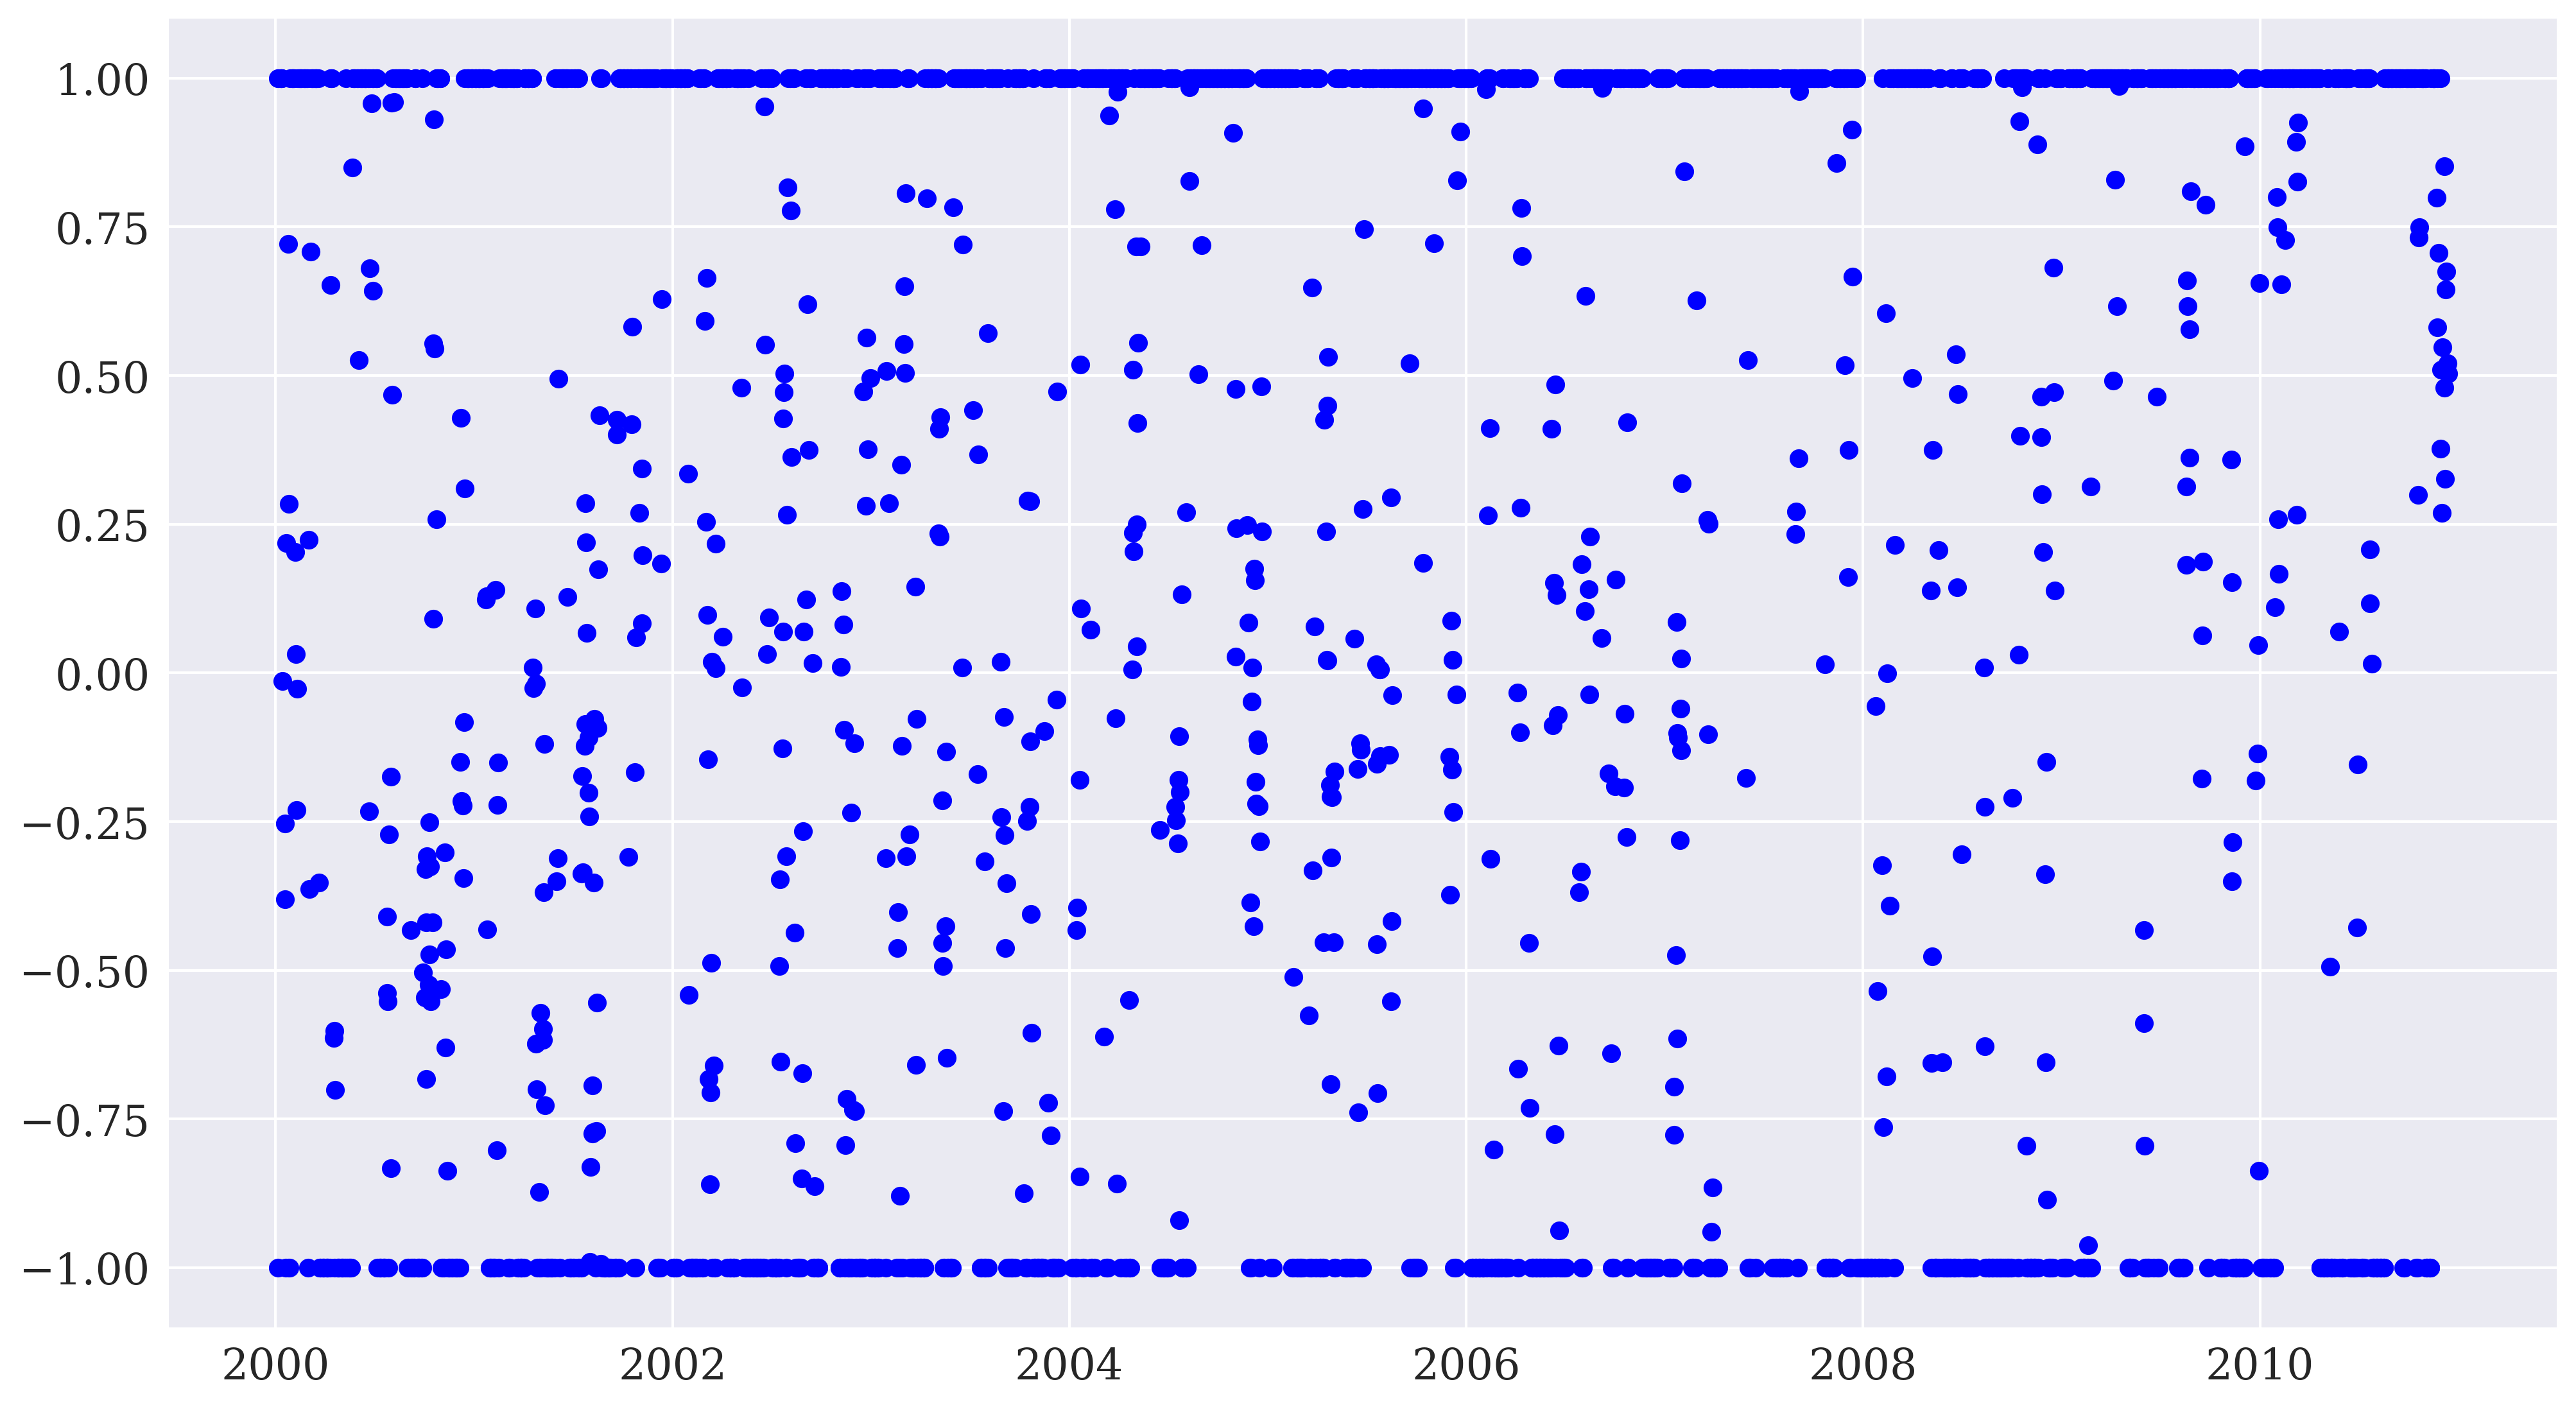

In [216]:
plt.plot(barriers.out,'bo')

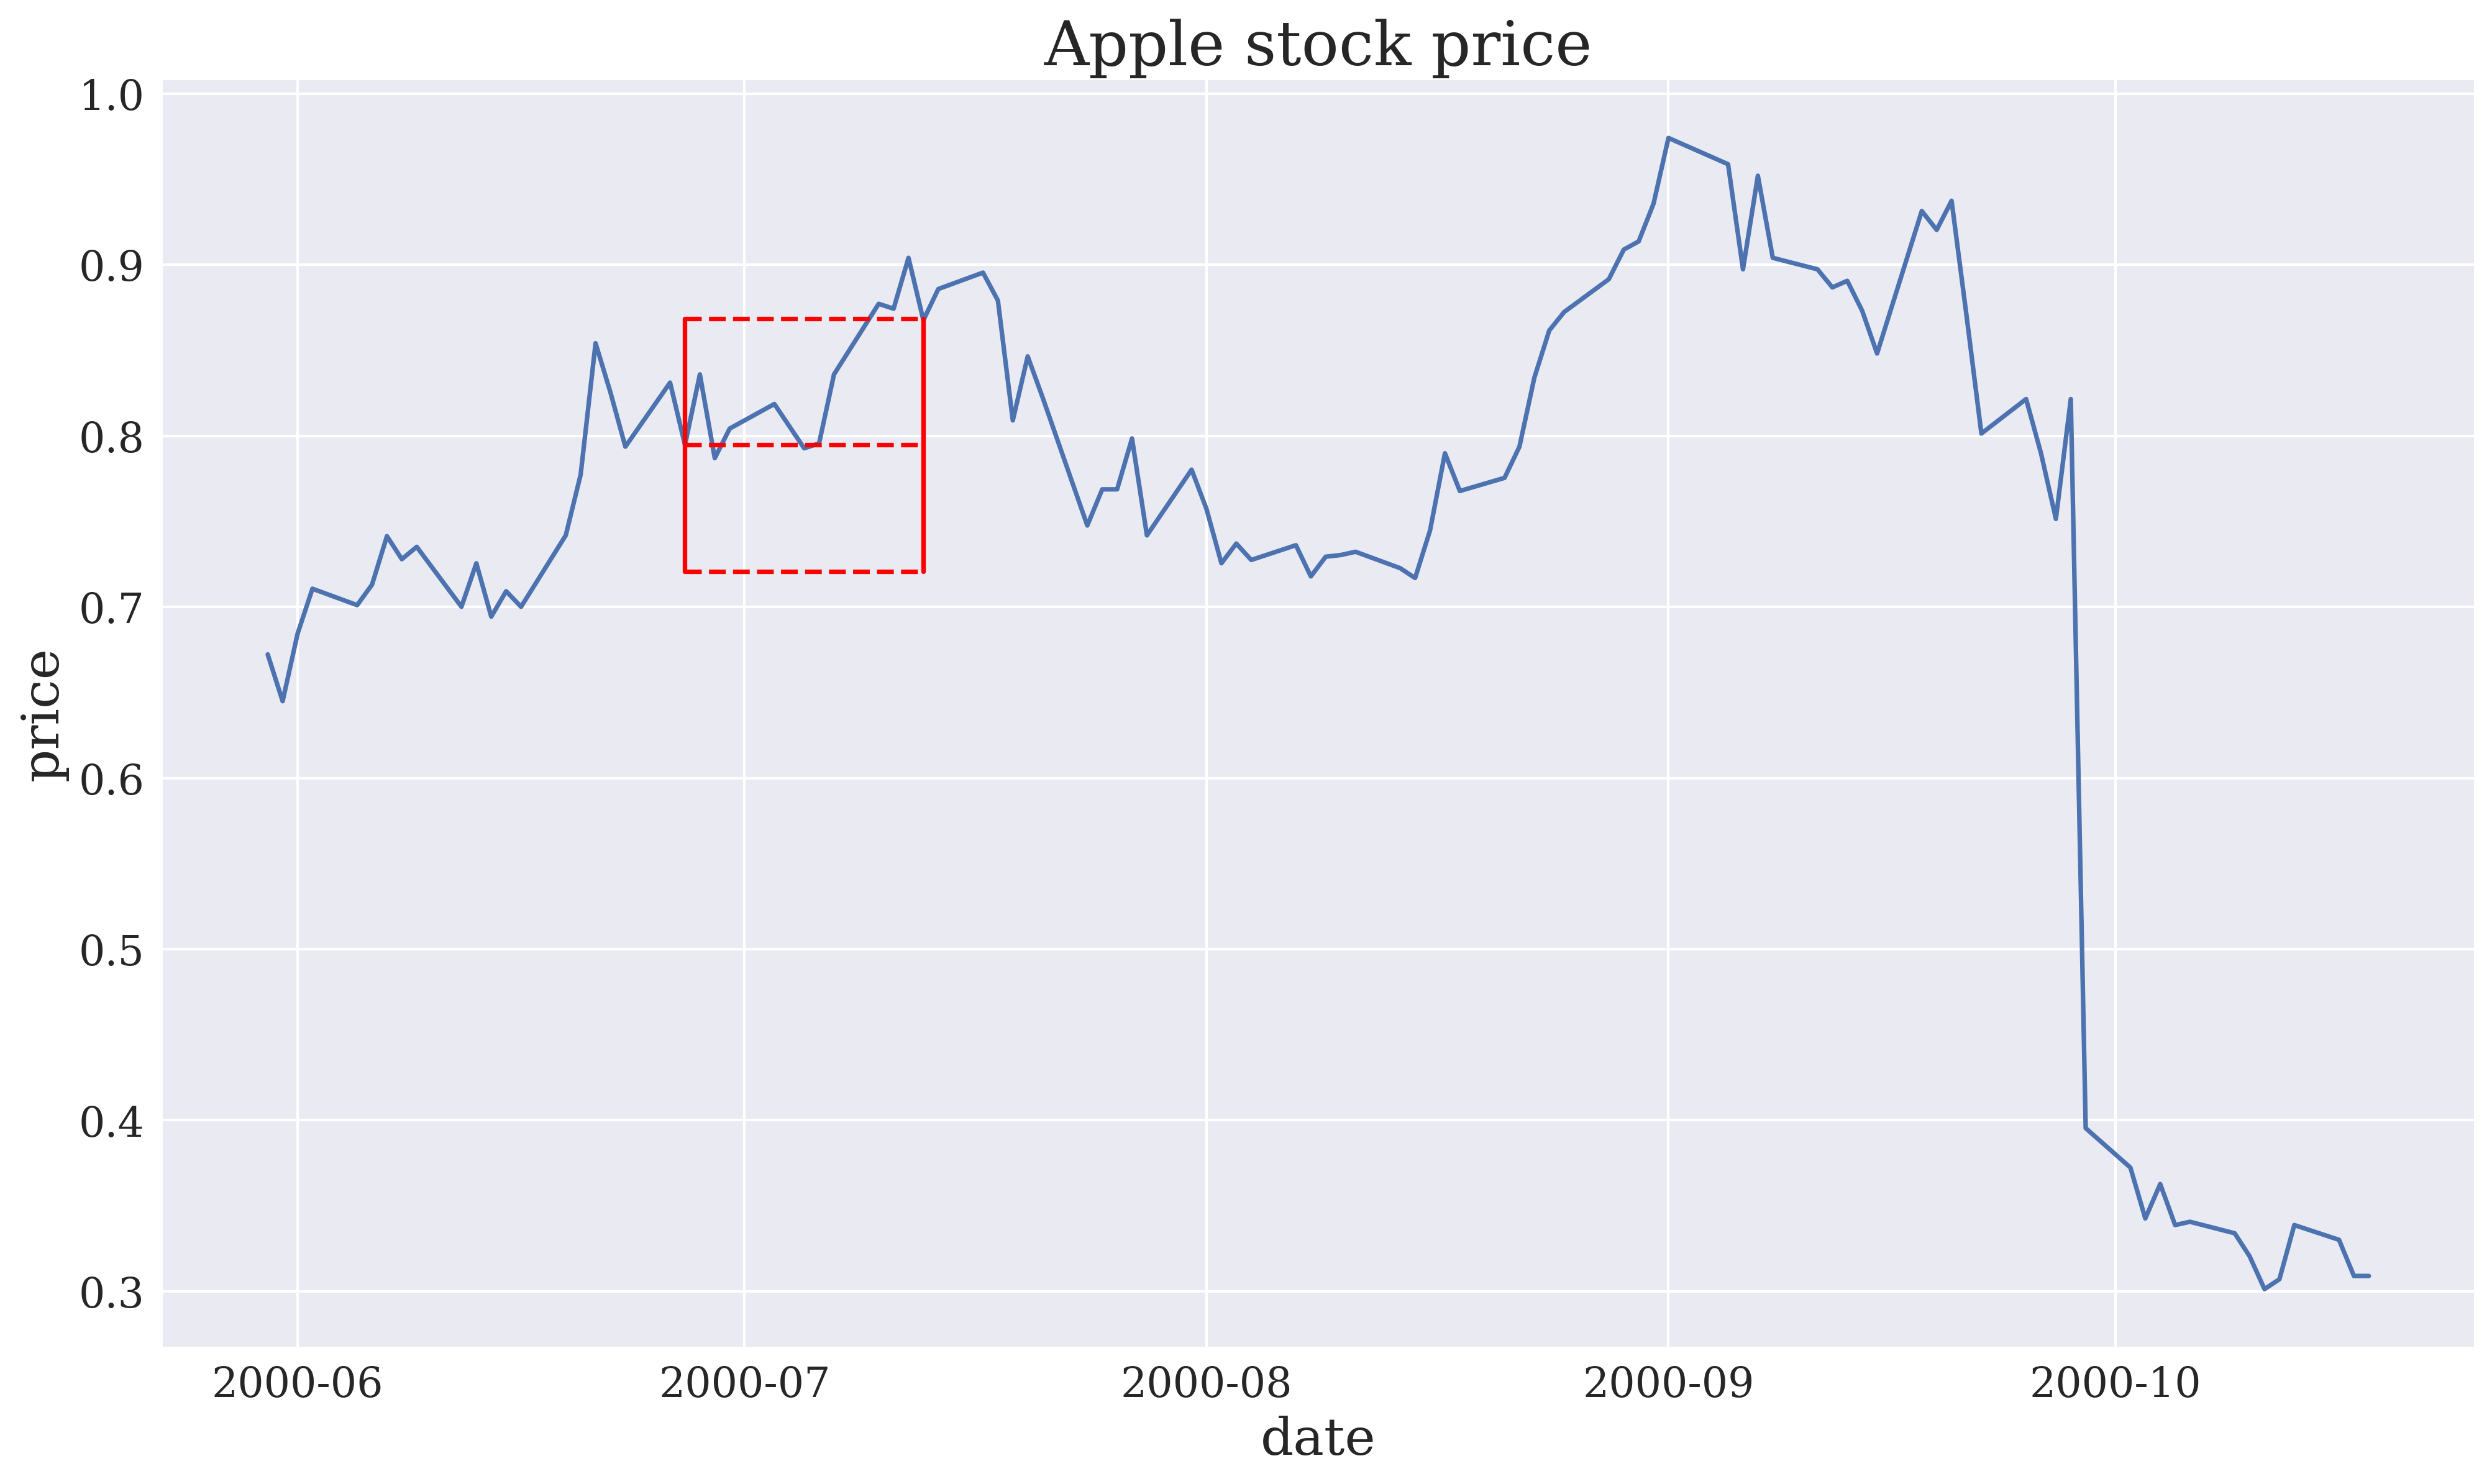

In [217]:
fig,ax = plt.subplots()
ax.set(title='Apple stock price',
       xlabel='date', ylabel='price')
ax.plot(barriers.price[100: 200])
start = barriers.index[120]
end = barriers.vert_barrier[120]
upper_barrier = barriers.top_barrier[120]
lower_barrier = barriers.bottom_barrier[120]
ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, \
                       (lower_barrier + upper_barrier)*0.5], 'r--');
ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');

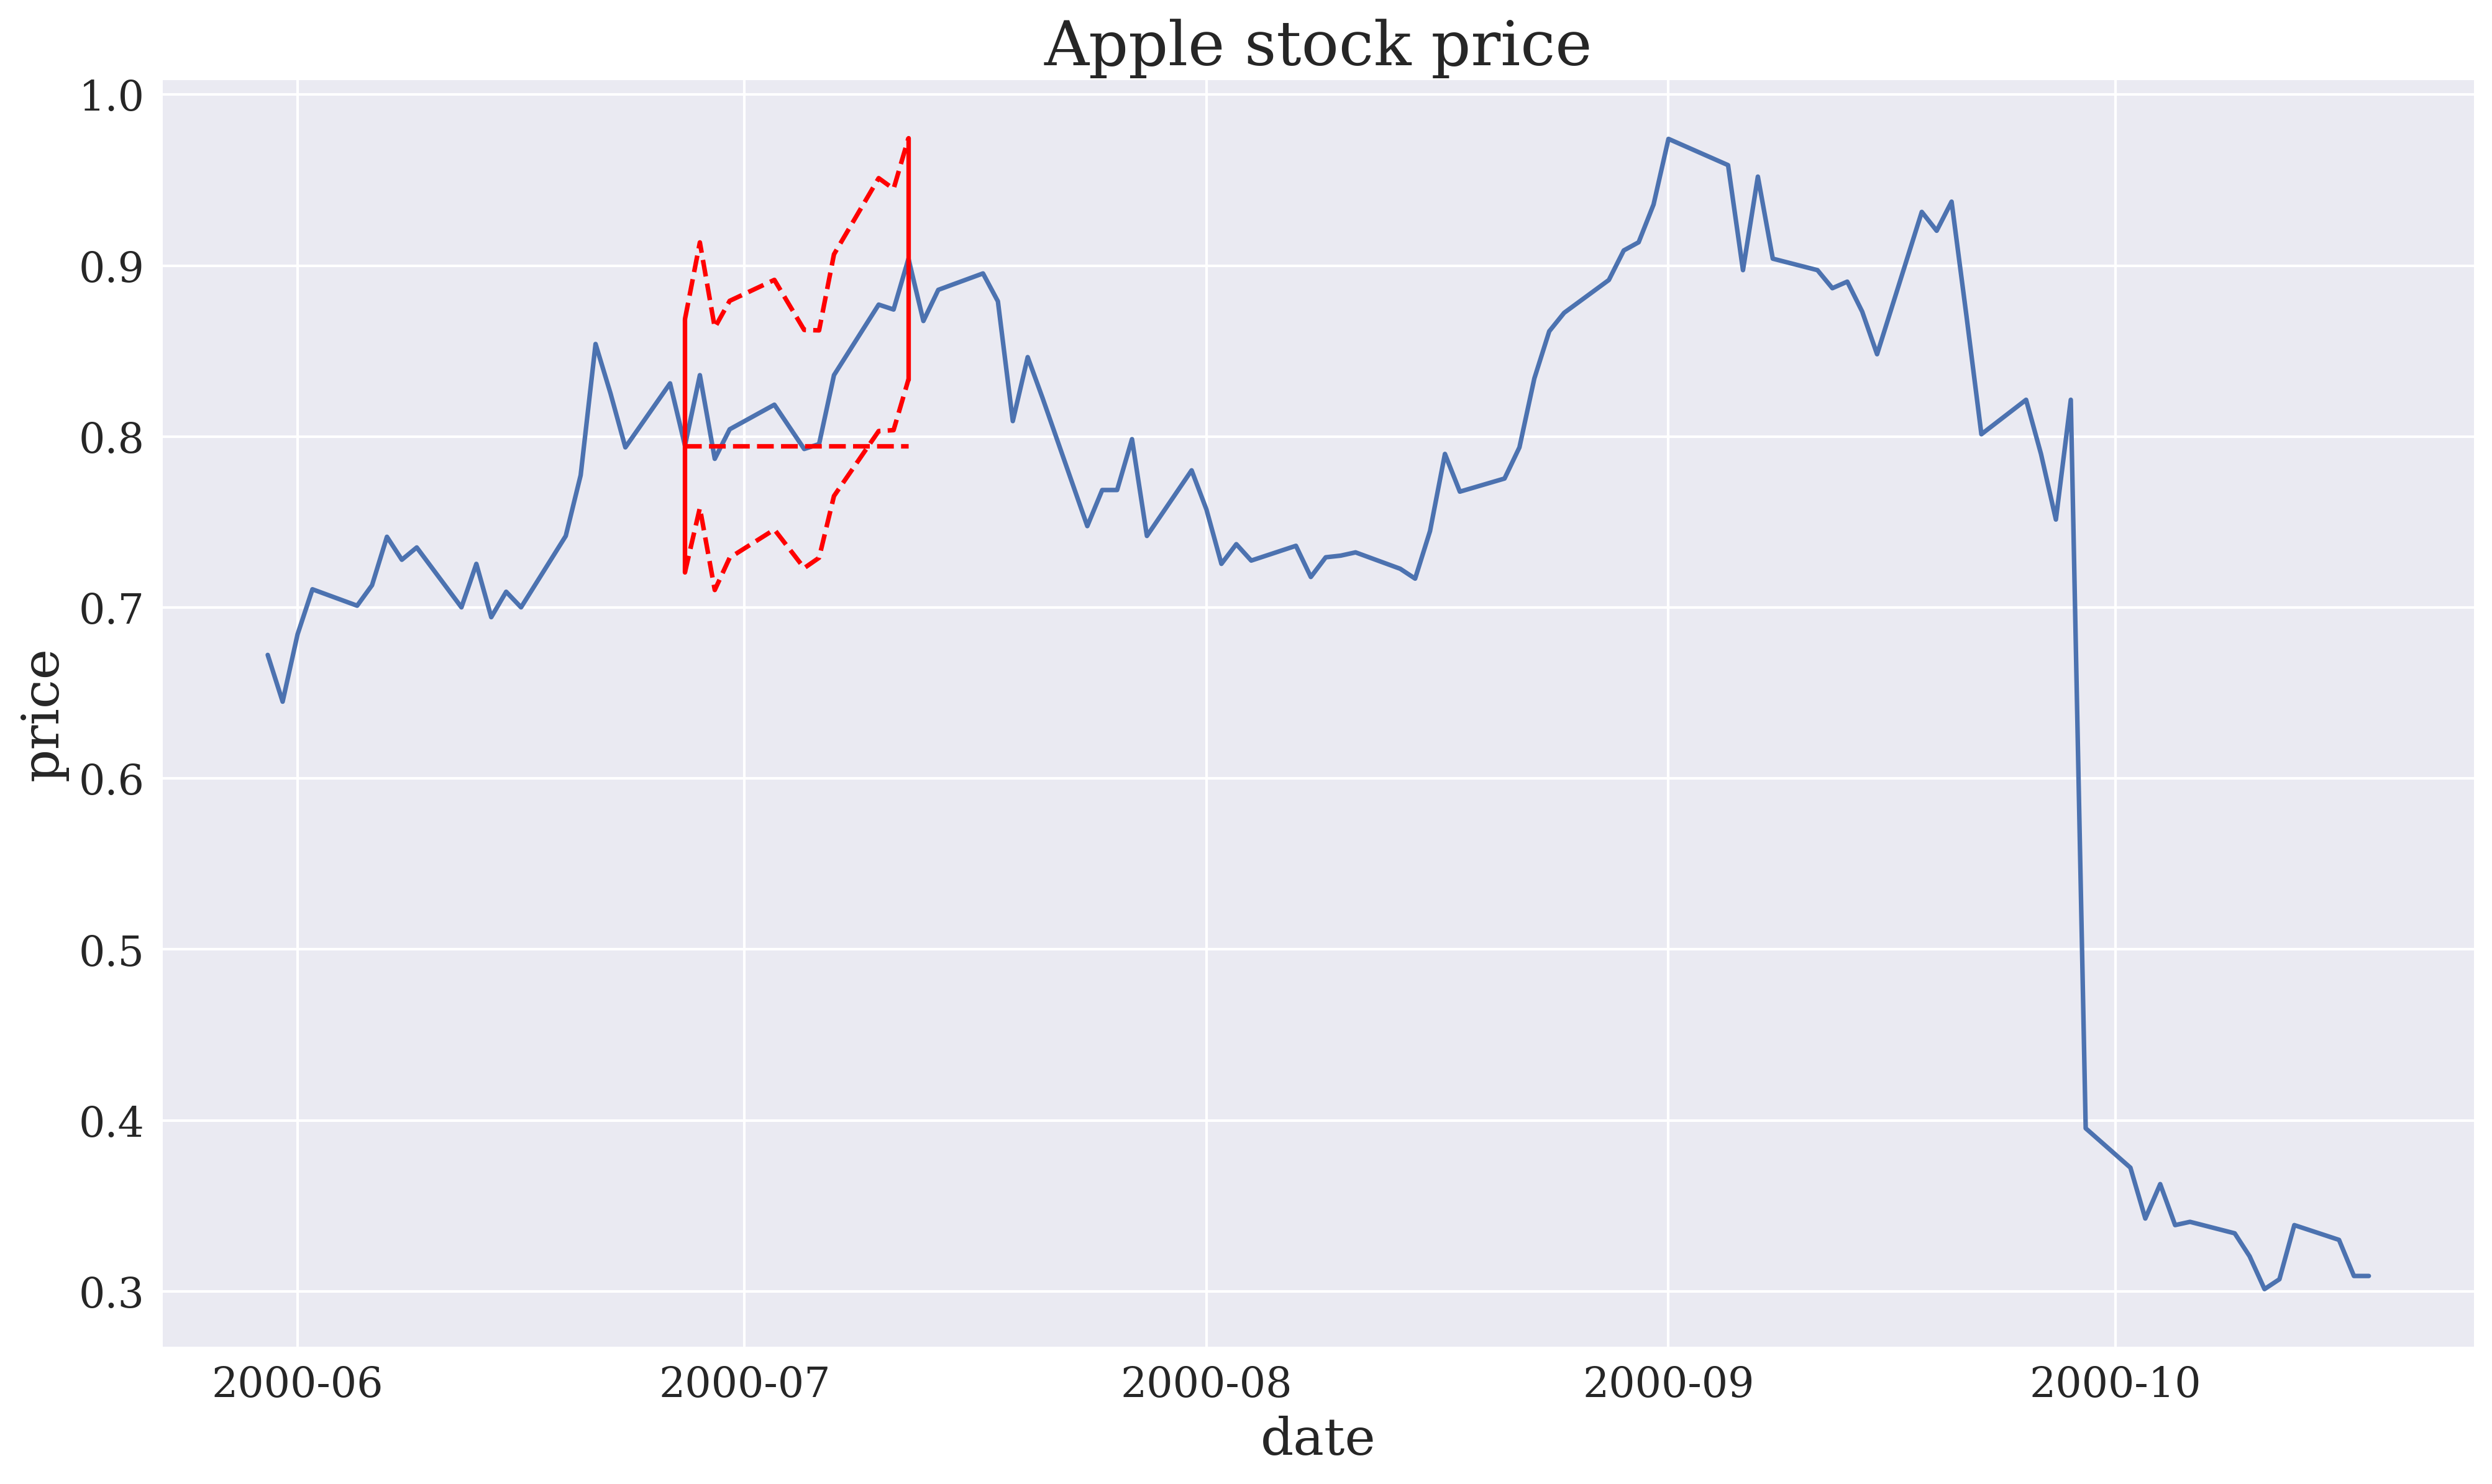

In [218]:
fig,ax = plt.subplots()
ax.set(title='Apple stock price',
       xlabel='date', ylabel='price')
ax.plot(barriers.price[100: 200])
start = barriers.index[120]
end = barriers.index[120+t_final]
upper_barrier = barriers.top_barrier[120]
lower_barrier = barriers.bottom_barrier[120]
ax.plot(barriers.index[120:120+t_final+1], barriers.top_barrier[start:end], 'r--');
ax.plot(barriers.index[120:120+t_final+1], barriers.bottom_barrier[start:end], 'r--');
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, \
                       (lower_barrier + upper_barrier)*0.5], 'r--');
ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
ax.plot([end, end], [barriers.bottom_barrier[end], barriers.top_barrier[end]], 'r-');

# Learning side and size

In [ ]:
def get_events(close, )

In [188]:
pd.NaT

NaT

# Meta labeling

The following image explains the model architecture. The first step is to train a primary model (binary classification) with a high recall. Second a threshold level is determined at which the primary model has a high recall, ROC curves could be used to help determine a good level. Third the features from the first model are concatenated with the predictions from the first model, into a new feature set for the secondary model. Meta labels are used as the target variable in the second model. Now fit the second model. Fourth the prediction from the secondary model is combined with the prediction from the primary model and only where both are true, is your final prediction true. I.e. if your primary model predicts a 3 and your secondary model says you have a high probability of the primary model being correct, is your final prediction a 3, else not 3.